In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv3D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.utils import to_categorical
import uuid
import base64

In [2]:
def prepare_data_tosplit(df, n_samples):
    df = df.sample(frac=1)
    df = df.iloc[0:n_samples]
    label_encoder = LabelEncoder()
    df['diagnostic'] = label_encoder.fit_transform(df['diagnostic'].tolist())
    y = to_categorical(df['diagnostic'].tolist(), num_classes=2)
    X = np.zeros((n_samples, 12, 250))
    for i in range(0, n_samples):
        X[i, :, :] = df.iloc[i]['data']
    return df, X, y

key = uuid.uuid4().hex[0:6]
df = pd.read_pickle('2022-02-02_02_05_35.pkl')
n_samples = 30000
df_new, X, y = prepare_data_tosplit(df, n_samples)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.reshape([*X_train.shape[0:3], 1])
X_test = X_test.reshape([*X_test.shape[0:3], 1])

In [12]:
df.iloc[0]

filename                                            JS09378.mat
inf                                                        2250
sup                                                        2500
data          [[-128.0879443366401, -104.21847447001475, -88...
db                                         WFDB_ChapmanShaoxing
diagnostic                                                   AF
Name: 44411, dtype: object

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(df[-12005:-12000]['diagnostic'].tolist())

array([0, 0, 0, 0, 0])

In [33]:
df[-12005:-12000]

,filename,inf,sup,data,db,diagnostic
93807,HR02315.mat,1250,1500,"[[40.8082854343957, 43.362680919792496, 47.216...",WFDB_PTBXL,SR
275589,E08755.mat,500,750,"[[-15.279765623817651, -8.146100864852983, -0....",WFDB_Ga,SR
330980,JS40257.mat,1750,2000,"[[-25.898049045259818, -37.91943631880605, -37...",WFDB_Ningbo,SR
301874,JS37347.mat,250,500,"[[112.88651052894889, 111.9215895021742, 111.7...",WFDB_Ningbo,SR
205553,HR15716.mat,250,500,"[[-72.34452059889557, -82.47658233565119, -88....",WFDB_PTBXL,SR


In [3]:
print(df_new[df_new.diagnostic == 1].shape)
print(df_new[df_new.diagnostic == 0].shape)
df_new.groupby(['diagnostic', 'db']).size()

(14942, 6)
(15058, 6)


diagnostic  db                  
0           WFDB_CPSC2018           5097
            WFDB_CPSC2018_2          641
            WFDB_ChapmanShaoxing    3532
            WFDB_Ga                 1640
            WFDB_PTBXL              4148
1           WFDB_CPSC2018            724
            WFDB_CPSC2018_2            2
            WFDB_ChapmanShaoxing     683
            WFDB_Ga                  936
            WFDB_Ningbo             3287
            WFDB_PTBXL              9310
dtype: int64

In [7]:
indexes = np.array(df_new.index)

with open(f'classification_data/{key}_indexes.npy', 'wb') as f:
    np.save(f, indexes)
    
# with open('classification_data/df_indexes.npy', 'rb') as f:
#   indexes = np.load(f)

,filename,inf,sup,data,db,diagnostic
44411,JS09378.mat,2250,2500,"[[-128.0879443366401, -104.21847447001475, -88...",WFDB_ChapmanShaoxing,AF
70423,HR17763.mat,250,500,"[[-107.89988426190651, -103.50782912232864, -9...",WFDB_PTBXL,AF
9018,A3330.mat,500,750,"[[80.2774680970738, 96.89598938208577, 130.342...",WFDB_CPSC2018,AF
40505,JS06384.mat,750,1000,"[[15.932645392231233, 9.929720055698139, 7.753...",WFDB_ChapmanShaoxing,AF
70000,HR17218.mat,2000,2250,"[[-14.919627355289675, -11.344026050587406, -1...",WFDB_PTBXL,AF
...,...,...,...,...,...,...
131090,HR06708.mat,2000,2250,"[[0.11071115119102179, 16.821644843473088, 26....",WFDB_PTBXL,SR
107662,HR03921.mat,0,250,"[[-8.788790370574128, -88.98056763364761, -162...",WFDB_PTBXL,SR
146251,HR08548.mat,2250,2500,"[[-44.052050494166345, -45.13386392416353, -43...",WFDB_PTBXL,SR
327193,JS39879.mat,0,250,"[[-78.57974147865943, -6.454119299492508, -55....",WFDB_Ningbo,SR


In [5]:
# https://github.com/mbarzegary/ecg-classification-keras-cnn/blob/master/train_keras.py
callbacks_list = [
  keras.callbacks.ModelCheckpoint(
      filepath=f'classification_data/{key}_model.h5',
      monitor='val_loss', save_best_only=True, verbose=1),
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
]

model = Sequential()
model.add(Conv2D(64, (4, 4), input_shape=X_train.shape[1:], padding='same', kernel_regularizer=l1_l2(0.0001, 0.0001), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.20))
model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.0001), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train,
                  batch_size=100,
                  epochs=10,
                  callbacks = callbacks_list,
                  verbose=1,
                  validation_data=(X_test, y_test))

2022-02-04 02:36:08.076565: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-04 02:36:08.076669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (renan-nitroan51554): /proc/driver/nvidia/version does not exist
2022-02-04 02:36:08.078633: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 250, 64)       1088      
                                                                 
 batch_normalization (BatchN  (None, 12, 250, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 250, 64)       65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 62, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 62, 64)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 62, 256)        2

2022-02-04 02:36:11.118659: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 241200000 exceeds 10% of free system memory.


Epoch 1/10


2022-02-04 02:36:13.221463: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 76800000 exceeds 10% of free system memory.
2022-02-04 02:36:13.305161: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 76800000 exceeds 10% of free system memory.
2022-02-04 02:36:13.367490: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 76800000 exceeds 10% of free system memory.
2022-02-04 02:36:13.573845: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19046400 exceeds 10% of free system memory.


201/201 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7348
Epoch 00001: val_loss improved from inf to 0.45561, saving model to classification_data/6d2698_model.h5
201/201 [==============================] - 425s 2s/step - loss: 0.6562 - accuracy: 0.7348 - val_loss: 0.4556 - val_accuracy: 0.8385
Epoch 2/10
201/201 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8555
Epoch 00002: val_loss improved from 0.45561 to 0.32657, saving model to classification_data/6d2698_model.h5
201/201 [==============================] - 379s 2s/step - loss: 0.4223 - accuracy: 0.8555 - val_loss: 0.3266 - val_accuracy: 0.9047
Epoch 3/10
201/201 [==============================] - ETA: 0s - loss: 0.3314 - accuracy: 0.9019
Epoch 00003: val_loss improved from 0.32657 to 0.29376, saving model to classification_data/6d2698_model.h5
201/201 [==============================] - 364s 2s/step - loss: 0.3314 - accuracy: 0.9019 - val_loss: 0.2938 - val_accuracy: 0.9193
Epoch 4

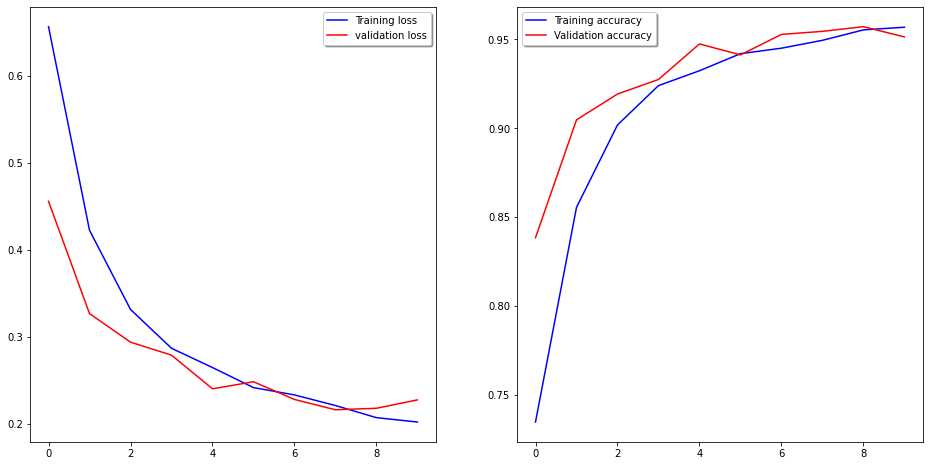

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(model.history['loss'], color='b', label="Training loss")
ax[0].plot(model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(model.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [3]:
loaded_model = load_model(f'classification_data/6d2698_model.h5')
y_pred = (loaded_model.predict(X_test) > 0.5).astype(np.int32)

2022-02-13 08:40:50.898685: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-13 08:40:50.898717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (renan-nitroan51554): /proc/driver/nvidia/version does not exist
2022-02-13 08:40:50.899754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 08:40:51.199006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 118800000 exceeds 10% of free system memory.


In [10]:
#y_pred_train = (loaded_model.predict(X_train) > 0.5).astype(np.int32)
accuracy_score(y_train.argmax(axis=1), y_pred_train.argmax(axis=1))

0.9586069651741294

<AxesSubplot:>

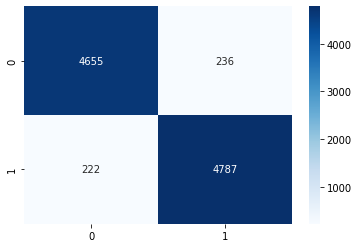

In [6]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = plt.subplot()
cmap = plt.get_cmap('Blues')
sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap)

In [8]:
print('[{:03d}] sensitivity'.format(10), matrix[0, 0] / (matrix[0, 1] + matrix[0, 0]))
print('[{:03d}] specificity'.format(10), matrix[1, 1] / (matrix[1, 1] + matrix[1, 0]))

[010] sensitivity 0.9517481087712124
[010] specificity 0.9556797764024756


In [8]:
accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

0.9594949494949495

In [9]:
f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='binary')

0.9595888340219692